In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [1]:
import os
import random

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

import pandas as pd

导入网络结构

In [2]:
#from __future__ import division
#from math import sqrt

class DoubleConV(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super(DoubleConV, self).__init__()
        self.pad = nn.ReplicationPad2d(1)
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, padding_mode='replicate', bias=False),
            #这里设置了bias = false, 应该相当于后面对bias取成全零矩阵，有待验证？
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, padding_mode='replicate', bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, X):
        return self.double_conv(X)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool = nn.Sequential(
            nn.MaxPool2d(2),
            #注：此处stride=None,但是Xin等设置了stride=2
            DoubleConV(in_channels, out_channels)
        )

    def forward(self, X):
        return self.maxpool(X)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super(Up, self).__init__()
        if bilinear:
            #self.up = nn.Upsample(scale_factor=2, model='bilnear', align_corners='True'),
            #bilinear双线性插值
            self.up = nn.UpsamplingBilinear2d(scale_factor=2)
            # scale_factor输出对输入的倍数，主要改变图片高宽，bilinear双线性插值
            self.conv = DoubleConV(in_channels, out_channels, in_channels//2)
            #self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1)
            #self.bn = nn.BatchNorm2d(out_channels)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            #没有加padding，待验证？
            self.conv = DoubleConV(in_channels, out_channels)
            #转置卷积，另外一种上采样的方式，不过一般都用双线性插值方法

    def forward(self, X1, X2):
        X1 = self.up(X1)
        #X1 = self.conv1(X1)
        #X1 = self.bn(X1)
        #将X1通道数减半
        #print(X2.size(),X1.size())
        if not (X2.size()[2] == X1.size()[2] or X2.size()[3] == X1.size()[3]):
            DetaX = X1.size()[2] - X2.size()[2]
            DetaY = X1.size()[3] - X2.size()[3]
            X2 = F.pad(X2, [DetaX // 2, DetaX - DetaX // 2,
                            DetaY // 2, DetaY - DetaY // 2], mode='replicate')
            #如果X1和X2大小不一样，将X2进行填充，到和X1相同的大小
            print('there is different cat_size, and we let X2 the same as X1 atomatically')
            #输出提示
        X = torch.cat([X2, X1], dim=1)
        #对每个通道的X1,X2整合到一起
        return self.conv(X)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, X):
        return self.conv(X)

In [3]:
class Unet(nn.Module):
    def __init__(self, colordim=1, n_classes=2, drop=0.5, bilinear=True):
        super(Unet, self).__init__()
        self.colordim = colordim
        self.n_classes = n_classes

        self.inp = DoubleConV(colordim, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512,1024//factor)
        self.up1 = Up(1024, 512//factor, bilinear)
        self.up2 = Up(512, 256//factor, bilinear)
        self.up3 = Up(256, 128//factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outp = OutConv(64, n_classes)
        #self.dropout = nn.Dropout(drop)

    def forward(self, X, drop=0.5):
        X1 = self.inp(X)
        X2 = self.down1(X1)
        X3 = self.down2(X2)
        X4 = self.down3(X3)
        #X4_1 = self.dropout(X4)
        X5 = self.down4(X4)
        #X5 = self.dropout(X5)
        X = self.up1(X5, X4)
        X = self.up2(X, X3)
        X = self.up3(X, X2)
        X = self.up4(X, X1)
        out = self.outp(X)
        return out

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_normal_(m.weight.data)
                nn.init.constant_(m.bias.data, 0.0)
            if isinstance(m, nn.BatchNorm2d):
                nn.init.xavier_normal_(m.weight.data)
                nn.init.constant_(m.bias.data, 0.0)

原子识别--图片预处理

In [4]:
import cv2
import torchvision
from PIL import Image,ImageFilter
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from skimage import transform

import sympy as sp

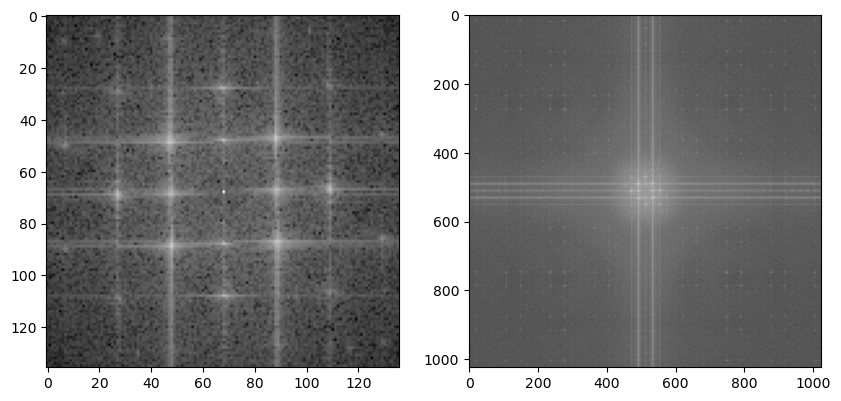

In [22]:
#找最小重复单元
#对去噪的图片（原图）进行傅里叶变换
image = Image.open("image_re_noise.jpg")

fft = np.fft.fft2(image)
fft_shift = np.fft.fftshift(fft)
fft_img = np.log(np.abs(fft_shift))

#fft_img = torch.tensor(fft_img)
fft_x, fft_y = fft_img.shape
plt.figure(figsize=(10,5))
#fft_crop_box = [int(fft_x/2-100):int(fft_x+100),int(fft_y/2-100):int(fft_y/2+100)]
plt.subplot(1,2,1)
plt.imshow(fft_img[int(fft_x/2-int(fft_x/15)):int(fft_x/2+int(fft_x/15)),
                   int(fft_y/2-int(fft_y/15)):int(fft_y/2+int(fft_y/15))],cmap='gray')
plt.subplot(1,2,2)
plt.imshow(fft_img,cmap='gray')

In [23]:
#像素归一化
def nor_pix(image): 
    # 将像素值转为浮点类型
    image = image.astype(np.float32)
    # 最大最小值归一化
    min_value = np.min(image)
    max_value = np.max(image)
    normalized_image = (image - min_value) / (max_value - min_value)
    
    return normalized_image

#像素转化为256
def pix_to_256(image):
    # 将像素值转为浮点类型
    image = image.astype(np.float32)
    # 最大最小值归一化
    min_value = np.min(image)
    max_value = np.max(image)
    normalized_image = 255*(image - min_value) / (max_value - min_value)
    
    return normalized_image

fft_img = nor_pix(fft_img)

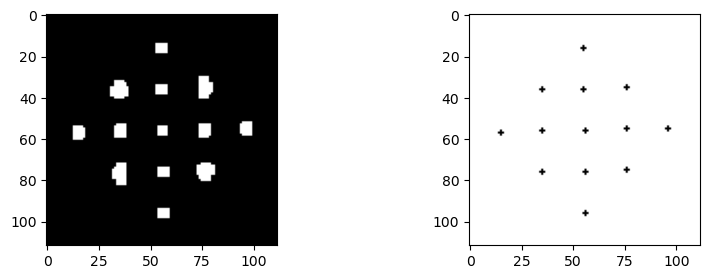

In [25]:
fft_img_cut = fft_img[int(fft_x/2-int(fft_x/18)):int(fft_x/2+int(fft_x/18)),
                      int(fft_y/2-int(fft_y/18)):int(fft_y/2+int(fft_y/18))]
#将图片保存
#matplotlib.image.imsave('ifft_cut.jpg',fft_img_cut,cmap='gray')
cv2.imwrite('fft_cut.jpg',fft_img_cut*255,params=[cv2.IMWRITE_PNG_COMPRESSION,0])


#这里需要根据情况调整阈值
ret,thresh = cv2.threshold(fft_img_cut, 0.77, 1, cv2.THRESH_BINARY)
#膨胀
thresh = cv2.dilate(thresh, None, iterations=2).astype("uint8")
#衍射点边缘
pat_contours, pat_hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
#print(contours)
pat_none1 = np.ones(thresh.shape)
pat_none2 = np.ones(thresh.shape)
#粗略估计衍射点位置
pat_cen_x = []
pat_cen_y = []
pat_r_sum = []
for con in pat_contours:
    area = cv2.contourArea(con)
    if area > 5:
        M = cv2.moments(con)
        pat_cont = cv2.drawContours(pat_none1,con,-1,[0,128,128],1)
        cx = int(M["m10"]/M["m00"])
        cy = int(M["m01"]/M["m00"])   #求质心
        r_i = pow(area/np.pi , 0.5)
        pat_cen_x.append(cx)
        pat_cen_y.append(cy)
        pat_r_sum.append(r_i)
        pat_cen = cv2.circle(pat_none2,(cx,cy),1,[0,0,0],-1)
#plt.figure(figsize=(100,50))
# trans = torchvision.transforms.ToTensor()
# thresh = trans(thresh)

plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.imshow(thresh,cmap='gray')
plt.subplot(1,2,2)
plt.imshow(pat_cen,cmap='gray')

2 92.86240522611175
7.25
66 87 43 64


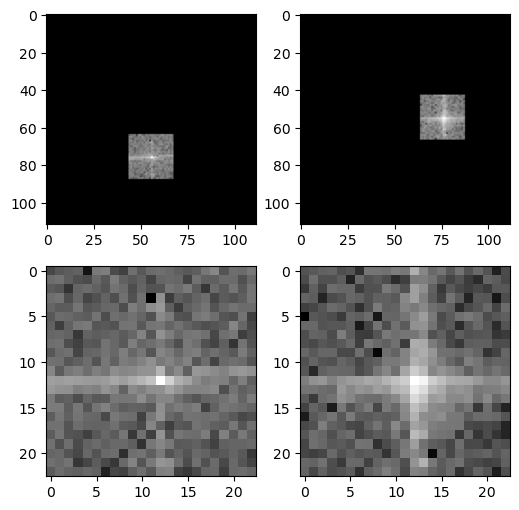

In [35]:
#计算衍射点到透射点的距离
fft_img_cut_x,fft_img_cut_y = fft_img_cut.shape

def disatance_cal(dot_x,dot_y,cen_x,cen_y):
    dis_to_cen = []
    for i in range(len(dot_x)):
        dis_to_cen_i = np.sqrt((dot_x[i]-cen_x/2)*(dot_x[i]-cen_x/2)
                              +(dot_y[i]-cen_y/2)*(dot_y[i]-cen_y/2))
        dis_to_cen.append(dis_to_cen_i)
    return dis_to_cen
    #print(i,dis_to_cen_i)

dis_to_cen = disatance_cal(pat_cen_x,pat_cen_y,fft_img_cut_x,fft_img_cut_y)

#定义一个排序的函数，返回排序后的结果以及用于排序的索引序列
def sort_(list_input):
    list_argsort = np.argsort(list_input)
    list_sort = np.sort(list_input)
    return list_argsort,list_sort

#与上面的区别：这里可以按自定义的序列来排list
def sort_list(list_input, sequence = np.array([1])):
    numpy_input = np.array(list_input)
    if sequence.all() == np.array([1]):
        sequence = np.argsort(numpy_input)
    numpy_output = numpy_input[sequence]
    list_output = numpy_output.tolist()
    return list_output,sequence

#mask转化为布尔数组,用来移除原图的背景信息
def remove_background(old_image,mask_img):
    mask_boolean = mask_img[:,:] ==0
    img_removed_background = old_image*mask_boolean
    return mask_boolean,img_removed_background

#衍射点到透射点的距离排序，从小到大
dis_to_cen, sequence = sort_list(dis_to_cen)
pat_cen_x, sq_x = sort_list(pat_cen_x,sequence)
pat_cen_y, sq_y = sort_list(pat_cen_y,sequence)


#定义两矢量夹角，矢量形式输入
def angle_vector(vector1,vector2):
    norm1 = np.linalg.norm(vector1)
    #norm1 = vector1.dot(vector1)
    norm2 = np.linalg.norm(vector2)
    dot_vector = vector1.dot(vector2)
    cos_vector = dot_vector/(norm1*norm2)
    theta_vector = np.arccos(cos_vector)*180/np.pi
    return theta_vector

#定义两矢量夹角，单个参量形式输入
def theta_of_vector_2d(A_x,A_y,B_x,B_y,O_x,O_y):
    dot = (A_x-O_x)*(B_x-O_x)+(A_y-O_y)*(B_y-O_y)
    length_A = np.sqrt((A_x-O_x)*(A_x-O_x)+(A_y-O_y)*(A_y-O_y))
    length_B = np.sqrt((B_x-O_x)*(B_x-O_x)+(B_y-O_y)*(B_y-O_y))
    cos_ = dot/(length_A*length_B)
    angle = np.arccos(cos_)*180/np.pi
    return angle

#寻找衍射点的基矢,从第二个和第三个开始取，第一个肯定为透射中心，主要排除共线情况
def find_vector(vector_1 = 1, vector_2 = 2):
    angle = 0
    while angle<10:
        angle = theta_of_vector_2d(pat_cen_x[vector_1],pat_cen_y[vector_1],
                                  pat_cen_x[vector_2],pat_cen_y[vector_2],
                                  pat_cen_x[0],pat_cen_y[0])
        vector_2 +=1
    vector_2 -=1
    #这边输出一下第二个矢量对应的索引
    print(vector_2,angle)
    return vector_1,vector_2

#判断衍射点mask的边长应该取多少，基础值就是边缘识别的半径
pat_r_max = max(pat_r_sum)
vec_1,vec_2 = find_vector(vector_1 = 1, vector_2 = 2)
#判断衍射点mask的边长应该取多少，加一个修正值，这边除以3为倍数，可以修改
# vec_1 = 1
# vec_2 = 5
resid = np.sqrt((pat_cen_x[vec_1]-pat_cen_x[vec_2])*(pat_cen_x[vec_1]-pat_cen_x[vec_2])
                +(pat_cen_y[vec_1]-pat_cen_y[vec_2])*(pat_cen_y[vec_1]-pat_cen_y[vec_2]))/4
print(resid)

pat_cut_none = np.ones(fft_img_cut.shape)
# print(vec_1,vec_2)
# vec_2 = 2
mask_1 = cv2.rectangle(pat_cut_none,(int(pat_cen_x[vec_1]-pat_r_max-resid),int(pat_cen_y[vec_1]-pat_r_max-resid)),
                                    (int(pat_cen_x[vec_1]+pat_r_max+resid),int(pat_cen_y[vec_1]+pat_r_max+resid)),[0,0,0],-1)
pat_cut_none = np.ones(fft_img_cut.shape)
mask_2 = cv2.rectangle(pat_cut_none,(int(pat_cen_x[vec_2]-pat_r_max-resid),int(pat_cen_y[vec_2]-pat_r_max-resid)),
                                    (int(pat_cen_x[vec_2]+pat_r_max+resid),int(pat_cen_y[vec_2]+pat_r_max+resid)),[0,0,0],-1)
print(int(pat_cen_y[vec_2]+pat_r_max+resid),int(pat_cen_x[vec_2]+pat_r_max+resid),
                                    int(pat_cen_y[vec_2]-pat_r_max-resid),int(pat_cen_x[vec_2]-pat_r_max-resid))
pat_mask_1,pat_reback_1 = remove_background(fft_img_cut,mask_1)
pat_mask_2,pat_reback_2 = remove_background(fft_img_cut,mask_2)
pat_reback_1_crop = pat_reback_1[int(pat_cen_y[vec_1]-pat_r_max-resid):int(pat_cen_y[vec_1]+pat_r_max+resid),
                                 int(pat_cen_x[vec_1]-pat_r_max-resid):int(pat_cen_x[vec_1]+pat_r_max+resid)]
pat_reback_2_crop = pat_reback_2[int(pat_cen_y[vec_2]-pat_r_max-resid):int(pat_cen_y[vec_2]+pat_r_max+resid),
                                 int(pat_cen_x[vec_2]-pat_r_max-resid):int(pat_cen_x[vec_2]+pat_r_max+resid)]
#转化为0-256像素，方便后续滤波
pat_reback_1_crop = pix_to_256(pat_reback_1_crop)
pat_reback_2_crop = pix_to_256(pat_reback_2_crop)

plt.figure(figsize=(6,6))
plt.subplot(2,2,1)
plt.imshow(pat_reback_1,cmap = 'gray')
cv2.imwrite('ifft_choose1.png',pat_reback_1,params=[cv2.IMWRITE_PNG_COMPRESSION,0])
plt.subplot(2,2,2)
plt.imshow(pat_reback_2,cmap = 'gray')
cv2.imwrite('ifft_choose2.png',pat_reback_2,params=[cv2.IMWRITE_PNG_COMPRESSION,0])
plt.subplot(2,2,3)
plt.imshow(pat_reback_1_crop,cmap = 'gray')
plt.subplot(2,2,4)
plt.imshow(pat_reback_2_crop,cmap = 'gray')

In [27]:
#定义cv2的滤波选择
def cv2_filter(image ,choose = 0, core = 3):
    #高斯滤波
    if choose == 1:
        image = cv2.GaussianBlur(image, (core,core), 0, 0)
    # 腐蚀操作
    elif choose == 2:
        kernel = np.ones((core,core), np.uint8)
        image = cv2.erode(image, kernel, iterations = 1)
    #高斯双边滤波
    elif choose == 3:
        image = cv2.bilateralFilter(image, d=1, sigmaColor=100, sigmaSpace=1)
    #中值滤波
    elif choose == 4:
        image = cv2.medianBlur(image,core)
        
    return image

C:\Users\shiki\AppData\Local\Temp\ipykernel_40288\1865578989.py:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.int(pat_max_x),np.int(pat_max_y)


True

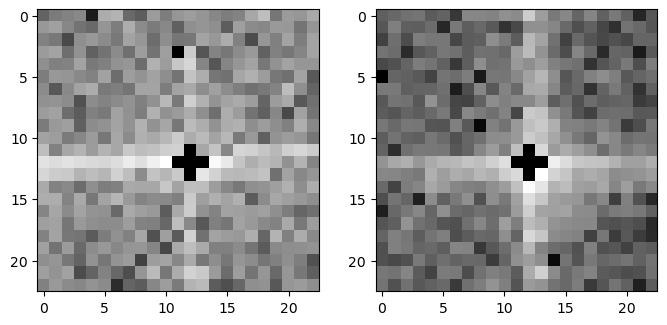

In [36]:
#默认不滤波，需要滤波修改choose的值
pat_reback_1_crop_filter = cv2_filter(pat_reback_1_crop.astype("uint8"),choose = 0, core = 3)
pat_reback_2_crop_filter = cv2_filter(pat_reback_2_crop.astype("uint8"),choose = 0, core = 3)

#定义寻找最大值位置函数
def find_fft_center(pat):
    sequence_x = []
    site = 0
    for i in np.amax(pat,axis=0):
        if i == np.amax(np.amax(pat,axis=0)):
            sequence_x.append(site)
        site += 1
    pat_max_x = np.round(np.average(sequence_x))

    sequence_y = []
    site = 0
    for i in np.amax(pat,axis=1):
        if i == np.amax(np.amax(pat,axis=1)):
            sequence_y.append(site)
        site += 1
    pat_max_y = np.round(np.average(sequence_y))
    return np.int(pat_max_x),np.int(pat_max_y)

#两个所选的衍射中心在mask之后衍射图的位置
pat_1_max_x,pat_1_max_y = find_fft_center(pat_reback_1_crop_filter)
pat_2_max_x,pat_2_max_y = find_fft_center(pat_reback_2_crop_filter)

#手动微调衍射点位置
def manul_adjust_fft(pat_x,pat_y,x_drift,y_drift):
    pat_x += x_drift
    pat_y += y_drift
    return pat_x,pat_y

#可以改变下面参数的值调整衍射中心位置，这里没有进行调整
pat_1_max_x,pat_1_max_y = manul_adjust_fft(pat_1_max_x,pat_1_max_y,0,0)
pat_2_max_x,pat_2_max_y = manul_adjust_fft(pat_2_max_x,pat_2_max_y,0,0)

pat_1_filter = cv2.circle(pat_reback_1_crop_filter, (pat_1_max_x,pat_1_max_y),1,[0,0,256],-1)
pat_2_filter = cv2.circle(pat_reback_2_crop_filter, (pat_2_max_x,pat_2_max_y),1,[0,0,256],-1)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(pat_1_filter,cmap='gray')
cv2.imwrite('ifft_cen_1.png',pat_1_filter,params=[cv2.IMWRITE_PNG_COMPRESSION,0])
plt.subplot(1,2,2)
plt.imshow(pat_2_filter,cmap='gray')
cv2.imwrite('ifft_cen_2.png',pat_2_filter,params=[cv2.IMWRITE_PNG_COMPRESSION,0])

20.0
[ 0  1  2  3  4  0 -1 -2 -3 -4]
56.0 55


C:\Users\shiki\AppData\Local\Temp\ipykernel_40288\3084646696.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  fft_shift_reback_copy = fft_shift_reback.astype("uint8").copy()


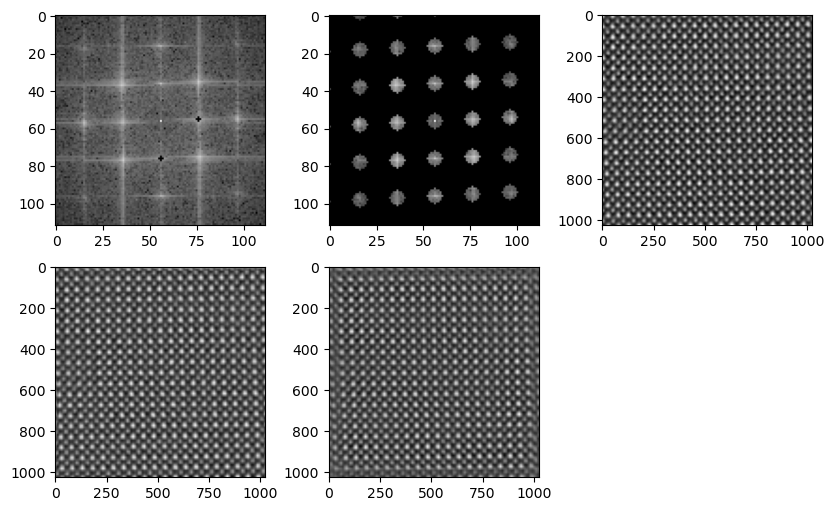

In [37]:
#两个所选的衍射中心在整张衍射图的位置
pat_1_max_x = int(pat_cen_x[vec_1]-pat_r_max-resid)+pat_1_max_x
pat_1_max_y = int(pat_cen_y[vec_1]-pat_r_max-resid)+pat_1_max_y
pat_2_max_x = int(pat_cen_x[vec_2]-pat_r_max-resid)+pat_2_max_x
pat_2_max_y = int(pat_cen_y[vec_2]-pat_r_max-resid)+pat_2_max_y
#选择mask的周期
epo_1 = np.max([np.abs(pat_1_max_x-fft_img_cut_x/2),np.abs(pat_1_max_y-fft_img_cut_y/2)])
epo_2 = np.max([np.abs(pat_2_max_x-fft_img_cut_x/2),np.abs(pat_2_max_y-fft_img_cut_y/2)])
print(epo_2)
per_1 = np.arange(int(fft_img_cut_x/epo_1))
per_1 = np.append(per_1,-per_1)
print(per_1)
per_2 = np.arange(int(fft_img_cut_x/epo_2))
per_2 = np.append(per_2,-per_2)
fft_img_cut_none = np.ones(fft_img_cut.shape)
#记录每个mask的位置
dif_vec_x = []
dif_vec_y = []
print(fft_img_cut_x/2,pat_2_max_y)
for i in per_1:
    for j in per_2:
        dif_vec_x_i = fft_img_cut_x/2+i*(pat_1_max_x-fft_img_cut_x/2)+\
                    j*(pat_2_max_x-fft_img_cut_x/2)
        dif_vec_y_i = fft_img_cut_y/2+i*(pat_1_max_y-fft_img_cut_y/2)+\
                    j*(pat_2_max_y-fft_img_cut_y/2)
        if (np.abs(dif_vec_x_i) < fft_img_cut_x) and (np.abs(dif_vec_y_i) < fft_img_cut_y):
            dif_vec_x.append(dif_vec_x_i)
            dif_vec_y.append(dif_vec_y_i)
            #print(i,j, fft_img_cut_x/2)
            fft_mask = cv2.circle(fft_img_cut_none,(int(dif_vec_x_i),int(dif_vec_y_i)),
                                  int(pat_r_max),[0,0,0],-1)

#对傅里叶变换mask，这里是对fft_img进行反傅里叶，结果并不准确,只是用来显示
fft_mask_output,fft_reback = remove_background(fft_img_cut,fft_mask)

#在空白图片上画出出所选的两个衍射点
#转化为0-256像素，方便后续滤波
fft_img_cut = pix_to_256(fft_img_cut)
fft_img_cut_copy = fft_img_cut.astype("uint8").copy()
fft_show_min = cv2.circle(fft_img_cut_copy,(pat_1_max_x,pat_1_max_y),1,[0,0,0],-1)
fft_show_min = cv2.circle(fft_img_cut_copy,(pat_2_max_x,pat_2_max_y),1,[0,0,0],-1)

#注意：做反傅里叶要对fft_shift进行，而不是对fft_img
fft_shift_cut = fft_shift[int(fft_x/2-int(fft_x/18)):int(fft_x/2+int(fft_x/18)),
                         int(fft_y/2-int(fft_y/18)):int(fft_y/2+int(fft_y/18))]
fft_shift_output,fft_shift_reback = remove_background(fft_shift_cut,fft_mask)

#去透射信息
fft_shift_reback_copy = fft_shift_reback.astype("uint8").copy()
fft_shift_reback_re = cv2.circle(fft_shift_reback_copy,(int(fft_img_cut_x/2),int(fft_img_cut_y/2)),
                                 int(pat_r_max+3),[0,0,0],3)

#定义反傅里叶变换的函数
def ifft(fshift):
    ishift = np.fft.ifftshift(fshift)
    iimg = np.fft.ifft2(ishift)
    iimg = np.abs(iimg)
    iimg = cv2.resize(iimg,image.size,interpolation = cv2.INTER_LINEAR)
    return iimg

#对没有剪切过的傅里叶变换图进行反傅里叶
ifft_0 = ifft(fft_shift)
#对剪切过的傅里叶变换图进行反傅里叶（选取中心区域）
ifft_cut = ifft(fft_shift_cut)
#对傅里叶变换mask之后的图进行反傅里叶
ifft_mask = ifft(fft_shift_reback)
#对傅里叶变换mask且去透射信息之后的图进行反傅里叶
ifft_mask_re = ifft(fft_shift_reback_re)

plt.figure(figsize=(10,6))
plt.subplot(2,3,1)
plt.imshow(fft_show_min,cmap='gray')
#保存基矢选取图片
#matplotlib.image.imsave('fft_vector.jpg',fft_show_min,cmap='gray')
cv2.imwrite('fft_vector.jpg',fft_show_min,params=[cv2.IMWRITE_PNG_COMPRESSION,0])
plt.subplot(2,3,2)
plt.imshow(fft_reback,cmap='gray')
#保存mask图片
#matplotlib.image.imsave('fft_mask.jpg',fft_reback,cmap='gray')
cv2.imwrite('fft_mask.jpg',fft_reback,params=[cv2.IMWRITE_PNG_COMPRESSION,0])
plt.subplot(2,3,3)
plt.imshow(ifft_0,cmap='gray')
plt.subplot(2,3,4)
plt.imshow(ifft_cut,cmap='gray')
plt.subplot(2,3,5)
plt.imshow(ifft_mask,cmap='gray')
# plt.subplot(2,3,6)
# plt.imshow(ifft_mask_re,cmap='gray')

In [12]:
#对图片增加灰条，防止缩放失真
def pad_img(image,size):
    iw,ih = image.size
    w,h = size
    scale = min(w/iw,h/ih)
    nw = int(iw*scale)
    nh = int(ih*scale)

    image = image.resize((nw,nh),Image.BICUBIC)
    new_image = Image.new('L',size,color=0)
    new_image.paste(image,((w-nw)//2,(h-nh)//2))
    #左上的坐标
    return new_image,nw,nh

#调用预测原子位置函数
def pred(image,box_size,periodicity):
    #备份原图
    old_image = image

    transform1 = torchvision.transforms.Compose([torchvision.transforms.Resize((256,256)),
                                               torchvision.transforms.ToTensor()])
    transform2 = torchvision.transforms.ToPILImage()
    output = Image.new('L',(256*periodicity,256*periodicity))
    for i in range(periodicity):
        for j in range(periodicity):
            box_ij = (box_size*i,box_size*j,box_size*(i+1),box_size*(j+1))
            image_ij = image.crop(box_ij)
            image_ij,nw,nh = pad_img(image_ij,(256,256))
            #备份原图
            old_image_ij = image_ij
            box = (int((256-nw)//2),int((256-nh)//2),int(256-(256-nw)//2),int(256-(256-nh)//2))
            old_image_ij = old_image_ij.crop(box)
            image_ij = transform1(image_ij)
            image_ij = torch.reshape(image_ij,(1,1,256,256))
            model = Unet()
            save_path = 'model.pth'
            model.load_state_dict(torch.load(save_path)['model_state_dict'])
            model.eval()
            #使用model.eval()来固定dropout和归一化层，否则每次推理会生成不同的结果
            with torch.no_grad():
                output_ij = model(image_ij)
            output_ij = torch.argmax(output_ij,dim=1)
            output_ij = torch.reshape(output_ij,(256,256))
            aveput_ij = np.average(output_ij)
            max_output_ij = output_ij.max()
            output_ij = output_ij/max_output_ij
            output_ij = output_ij.float()
            output_ij = transform2(output_ij)
            #把灰条部分截取
            output_ij = output_ij.crop(box)
            output.paste(output_ij,box = (256*i,256*j,256*(i+1),256*(j+1)))

    return old_image,output

In [13]:
#中心寻找法1，用于实际识别
def find_center(image,erode_core = (4,4),area_thre = 0.5):
    #先腐蚀，去除一些噪点
    kernel = np.ones(erode_core, np.uint8)
    output_erode = cv2.erode(image, kernel, iterations = 1)  #腐蚀
    output_none1 = np.ones(output_erode.shape)
    output_none2 = np.ones(output_erode.shape)
    contours, hierarchy = cv2.findContours(output_erode, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    #print(contours)
    cen_x = []
    cen_y = []
    area_sum = []
    r_sum = []
    #记录所有的面积
    for con in contours:
        area = cv2.contourArea(con)
        area_sum.append(area)

    mean_area = np.mean(area_sum)
    max_area = max(area_sum)

    #重置
    area_sum = []
    for con in contours:
        area = cv2.contourArea(con)
        #设置一个面积阈值，在此之下的不予考虑，进一步去除噪点
        if area > area_thre * mean_area:
            M = cv2.moments(con)
            output_cont = cv2.drawContours(output_none1,con,-1,[0,128,128],1)
            cx = int(M["m10"]/M["m00"])
            cy = int(M["m01"]/M["m00"])   #求质心
            cen_x.append(cx)
            cen_y.append(cy)
            area_sum.append(area)
            r_i = pow(area/np.pi , 0.5)
            r_sum.append(r_i)
            output_cen = cv2.circle(output_none2,(cx,cy),1,[0,0,0],-1)
    return output_erode,output_cont,output_cen,cen_x,cen_y,area_sum

C:\Users\shiki\AppData\Local\Temp\ipykernel_23004\2072346107.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  edge = np.int(x*edge)


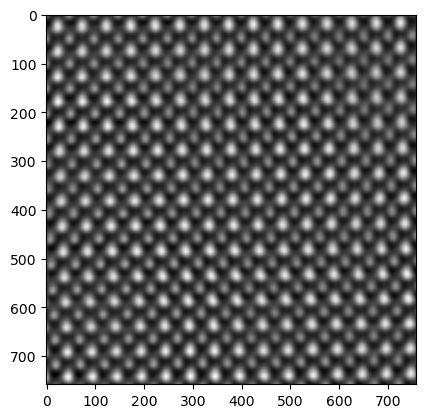

In [14]:
def remove_edge(image,edge = 0.1):
    x,y = image.shape
    edge = np.int(x*edge)
    image = image[edge:x-edge,edge:y-edge]
    
    #image = np.resize(image, (x, y))
    return image

#我们只是找最小格子，所以可以对边缘进行裁剪，去除失真区域
ifft_mask_edge = remove_edge(ifft_mask,edge = 0.13)
#保存反傅里叶变换图片
#ifft_mask_edge = ifft_mask_edge.resize((1024,1024))
#matplotlib.image.imsave('ifft_image.jpg',ifft_mask_edge,cmap='gray')
cv2.imwrite('ifft_image.png',ifft_mask_edge,params=[cv2.IMWRITE_PNG_COMPRESSION,0])
plt.imshow(ifft_mask_edge,cmap = 'gray')
plt.show()

In [15]:
#读取原来的图片,并进行原子位置识别，方便后面进行漂移矫正
image = Image.open('image_re_noise.jpg').convert('L')
ori_image,output = pred(image,256,4)
#将两张图片混合
ori_image = ori_image.resize(output.size)

trans_totensor = torchvision.transforms.ToTensor()
output = output.convert("L")
output = trans_totensor(output).permute(1,2,0).numpy()
output = output.astype("uint8")

#中心寻找法1
output_erode,output_cont,output_cen,cen_x,cen_y,area_sum = find_center(output)

C:\Users\shiki\AppData\Local\Temp\ipykernel_23004\1101122574.py:9: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  image = image.resize((nw,nh),Image.BICUBIC)


In [16]:
#读取像素值和长度之间的转化比，方便后续定量

#加下来的图片都在此图片操作
origin_image = cv2.imread('image_re_noise.jpg')
origin_image = cv2.cvtColor(origin_image, cv2.COLOR_BGR2GRAY)
origin_image = origin_image.astype(np.float32)

#读取标尺图片
scale_img = cv2.imread('022_scale.tif')
scale_img = cv2.cvtColor(scale_img, cv2.COLOR_BGR2GRAY)
scale_img = scale_img.astype(np.float32)
#标尺对应实际长度：/nm
scale = 2

scale_img.resize(origin_image.shape)
#归一化
scale_img = (scale_img-scale_img.min())/(scale_img.max()-scale_img.min())

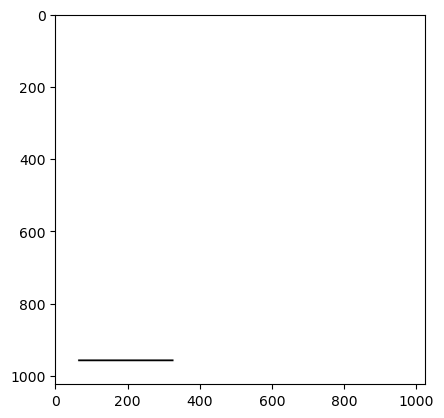

In [17]:
img_x,img_y = scale_img.shape
scale_x = []
for i in range(img_y):
    for j in range(img_x):
        if scale_img[i,j]==0:
            scale_x.append(j)
scale_pix = np.max(scale_x) - np.min(scale_x)
#像素值和长度的转化系数，单位nm
trans_pix_to_nm = scale/scale_pix

plt.imshow(scale_img,cmap='gray')
plt.show()

In [18]:
#定义矢量夹角计算
def angle_vector(vector1,vector2):
    norm1 = np.linalg.norm(vector1)
    #norm1 = vector1.dot(vector1)
    norm2 = np.linalg.norm(vector2)
    dot_vector = vector1.dot(vector2)
    cos_vector = dot_vector/(norm1*norm2)
    theta_vector = np.arccos(cos_vector)*180/np.pi
    return theta_vector


#以一个点为原点，找下一个点，构成矢量a
def find_next_o(a,cen_x,cen_y,o_x,o_y):
    #计算所有矢量和a的夹角并且从小到大排序
    angle_of_a = []
    #记录所有点到o的距离
    distance = []
    for i in range(len(cen_x)):
        atom_vec_i = np.array([cen_x[i]-o_x,cen_y[i]-o_y])
        distance.append(np.linalg.norm(atom_vec_i))
        angle_of_a_i = angle_vector(atom_vec_i,a)
        angle_of_a.append(angle_of_a_i)

    distance_argsort = np.argsort(distance)
    distance_sort = np.sort(distance)

    #确定长度
    output_index = 0
    len_of_a = 0
    for i in range(len(distance_sort)):
        #这里要做三个限制：不能是原点；只能在附近的8个点找；
        #夹角要小于0.3度（这个可以视情况增加，即非线性漂移较大则可以选择性增加）
            #print(angle_of_a[distance_argsort[i]])
        if i != 0 and i < 12 and angle_of_a[distance_argsort[i]] < 5:
            len_of_a = distance_sort[i]
            #记录对应索引，注意，这里的索引是对应到distance_argsort
            output_index = i
        elif i > 8:
             break
    
    a_x = cen_x[distance_argsort[output_index]]
    a_y = cen_y[distance_argsort[output_index]]
    
    #设置一个标记，到达该标记后即遍历到了另外一端，数据作废
    if output_index == 0:
         a_x = a_y = 0   
    
    return len_of_a, a_x, a_y

In [19]:
#求变换矩阵T0
def drift_T_0(standard_a0,standard_b0,a_0,b_0):
    #定义变量
    s_x, s_y, lamadax, lamaday = sp.symbols('s_x s_y lamadax lamaday')
    #定义方程
    Eq1 = sp.Eq(s_x*a_0[0]+s_x*lamadax*a_0[1],standard_a0[0])
    Eq2 = sp.Eq(s_y*a_0[1]+s_y*lamaday*a_0[0],standard_a0[1])
    Eq3 = sp.Eq(s_x*b_0[0]+s_x*lamadax*b_0[1],standard_b0[0])
    Eq4 = sp.Eq(s_y*b_0[1]+s_y*lamaday*b_0[0],standard_b0[1])
    equations = [Eq1, Eq2, Eq3, Eq4]
    # 解方程组
    sol = sp.solve(equations, (s_x, s_y, lamadax, lamaday))
    # 打印解
    #print(sol)
    T = np.array([[sol[s_x],sol[s_x]*sol[lamadax]],
                    [sol[s_y]*sol[lamaday],sol[s_y]]])
    #print(sol[s_x], sol[s_y], sol[lamadax], sol[lamaday],T)
    
    return T

In [20]:
def paint_point(image,x,y):
    output = cv2.circle(image,(x,y),3,[0,0,0],2)
    plt.imshow(output,cmap='gray')
    plt.show()

In [21]:
#定义一个排序函数，对矢量夹角排序
def sort_angle_of_vector(cen_x,cen_y,o_x,o_y,vector):
    angle_of_vector = []
    for i in range(len(cen_x)):
        atom_vec_i = np.array([cen_x[i]-o_x,cen_y[i]-o_y])
        angle_of_vector_i = angle_vector(atom_vec_i,vector)
        angle_of_vector.append(angle_of_vector_i)
    angle_of_vector_sort = np.sort(angle_of_vector)
    return angle_of_vector_sort

In [29]:
#从倒易空间确定正空间格子两个归一化基矢方向,作为矫正漂移的基准
a_star = np.array([pat_1_max_x-fft_img_cut_x/2,pat_1_max_y-fft_img_cut_y/2])
b_star = np.array([pat_2_max_x-fft_img_cut_x/2,pat_2_max_y-fft_img_cut_y/2])
print('angle of a* b*:', angle_vector(a_star,b_star))
a_0 = np.array([-(pat_1_max_y-fft_img_cut_y/2),pat_1_max_x-fft_img_cut_x/2])/np.linalg.norm(a_star)
b_0 = np.array([-(pat_2_max_y-fft_img_cut_y/2),pat_2_max_x-fft_img_cut_x/2])/np.linalg.norm(b_star)
x = np.array([1,0])
y = np.array([0,1])
if np.cross(a_0,y) < 0:
    a_0 = -a_0
if np.cross(b_0,y) < 0:
    b_0 = -b_0

#定一个原子为原点
dis_to_O = []
for i in range(len(cen_x)):
    dis_to_O_i = np.sqrt(cen_x[i]*cen_x[i]+cen_y[i]*cen_y[i])
    dis_to_O.append(dis_to_O_i)
#将到左上角的距离排序，取最近的一个原子为原点
dis_to_O_argsort = np.argsort(dis_to_O)
dis_to_O_sort = np.sort(dis_to_O)
#为了保证取的是整个原子，增加一个判据，即所去原子边缘面积应该大于0.7倍平均面积
atom_area_mean = np.mean(area_sum)
atom_r_mean = np.sqrt(atom_area_mean/np.pi)

for i in range(len(dis_to_O_argsort)):
    if area_sum[dis_to_O_argsort[i]] > 0.6*atom_area_mean:
        o_x,o_y = cen_x[dis_to_O_argsort[i]],cen_y[dis_to_O_argsort[i]]
        if np.abs(1- o_x / o_y) < 0.5:
            break

origin_image = cv2.imread('image_re_noise.jpg')
origin_image = cv2.cvtColor(origin_image, cv2.COLOR_BGR2GRAY)
origin_image = origin_image.astype(np.float32)


#计算所有矢量和a_0，b_0的夹角并且从小到大排序

angle_of_A_sort = sort_angle_of_vector(cen_x,cen_y,o_x,o_y,a_0)
angle_of_B_sort = sort_angle_of_vector(cen_x,cen_y,o_x,o_y,b_0)

#如果和a_0，b_0的夹角中的最小值过大，表示a_0，b_0方向并不准确，进行修正
#注意这里为首的是大写的O
cen_O = np.array([o_x,o_y])
#对基矢长度进行初始化
len_of_a0, a_x, a_y = find_next_o(a_0,cen_x,cen_y,o_x,o_y)
len_of_b0, b_x, b_y = find_next_o(b_0,cen_x,cen_y,o_x,o_y)


#情况2：选择最近邻的点作为基矢
oA = np.array([a_x,a_y])-cen_O
oB = np.array([b_x,b_y])-cen_O   

#paint_point(origin_image,a_x,a_y)
#更新基矢长度
len_of_a0 = np.linalg.norm(oA)/np.round(np.linalg.norm(oA)/len_of_a0)
len_of_b0 = np.linalg.norm(oB)/np.round(np.linalg.norm(oB)/len_of_b0)

#更新后准确的正空间基矢
a_0 = len_of_a0*oA/np.linalg.norm(oA)
b_0 = len_of_b0*oB/np.linalg.norm(oB)

angle of a* b*: 92.86240522611175


C:\Users\shiki\AppData\Local\Temp\ipykernel_23004\3184598420.py:7: RuntimeWarning: invalid value encountered in double_scalars
  cos_vector = dot_vector/(norm1*norm2)


In [31]:
#a_0,b_0转化为nm
nm_a_0 = np.linalg.norm(a_0)*trans_pix_to_nm
nm_b_0 = np.linalg.norm(b_0)*trans_pix_to_nm
print(nm_a_0,nm_b_0)
print(a_0,b_0)

ori_a_0 = a_0
ori_b_0 = b_0

print(angle_vector(ori_a_0,ori_b_0))

0.3727011636454097 0.38783269961977185
[49. -1.] [ 0. 51.]
91.16913932790743


In [48]:
#先将图片进行非线性漂移矫正到a0，b0方向

In [32]:
#矫正线性漂移
#输入标准数值
len_of_standard_a0 = 0.3905
len_of_standard_b0 = 0.3905

#这个是调整a，b比例不变
# len_of_standard_b0 = len_of_b0/len_of_a0
# print(len_of_standard_b0)

standard_angel = 90
#根据情况设置a_0的方向，并根据设置以及输入来输出线性漂移矫正的矩阵
#a_b_x_y:1:以a为标准;2:以b为标准
#        3:以x轴为标准(1,0);4:以y轴为标准(0,1)
def standard_one_vector(a_0, b_0, a_b_x_y = 3, len_of_standard_a0=1,len_of_standard_b0=1, standard_angel=90, trans_pix_to_nm = 0.1):
    choose = a_b_x_y
    #转化为弧度
    standard_angel = np.pi*standard_angel/180
    #实际长度转像素值
    len_of_standard_a0 = len_of_standard_a0/trans_pix_to_nm
    len_of_standard_b0 = len_of_standard_b0/trans_pix_to_nm
    if choose == 1 or choose == 3:
        if choose == 1:
            standard_a0 = len_of_standard_a0*a_0/np.linalg.norm(a_0)
        else:
            standard_a0 = len_of_standard_a0*np.array([1,0])
        #旋转矩阵
        rota_mat = np.array([[-np.cos(standard_angel),-np.sin(standard_angel)],
                           [np.sin(standard_angel),-np.cos(standard_angel)]])
        standard_b0 = len_of_standard_b0*np.dot(rota_mat,standard_a0)/len_of_standard_a0
        #print(rota_mat, standard_a0, np.dot(rota_mat,standard_a0))
    elif choose == 2 or choose == 4:
        if choose == 2:
            standard_b0 = len_of_standard_b0*b_0/np.linalg.norm(b_0)
        else:
            standard_b0 = len_of_standard_b0*np.array([1,0])
        #旋转矩阵
        rota_mat = np.array([[np.cos(standard_angel),np.sin(standard_angel)],
                           [-np.sin(standard_angel),np.cos(standard_angel)]])
        standard_a0 = len_of_standard_a0*np.dot(rota_mat,standard_b0)/len_of_standard_b0

    #这个即通过比较给出的标准数值和从倒空间得到的正空间基矢，得到的变化矩阵T0，线性漂移矫正的矩阵
    
   # print(standard_a0,standard_b0,a_0,b_0)
    
    T_0 = drift_T_0(standard_a0,standard_b0,a_0,b_0)
    t = np.array([0,0])
    T_0 = np.hstack((T_0,t.reshape((-1, 1))))
    #print(standard_a0,standard_b0)
    
    return T_0,standard_a0,standard_b0

#线性漂移的矩阵
T_0,standard_a0,standard_b0 = standard_one_vector(a_0, b_0, a_b_x_y = 3, 
                              len_of_standard_a0=len_of_standard_a0,
                              len_of_standard_b0=len_of_standard_b0, 
                              standard_angel=standard_angel,
                              trans_pix_to_nm = trans_pix_to_nm)

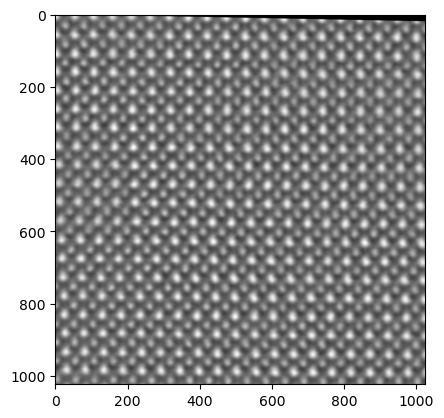

In [35]:
#对图片进行线性漂移矫正操作,仅在无非线性漂移的情况下有效
#进行透视变换
img_x,img_y = origin_image.shape
#注意这里要改变T_0的类型
T_0_image = cv2.warpAffine(origin_image, T_0.astype(np.float32), (img_x,img_y))

plt.imshow(T_0_image,cmap='gray')
plt.show()

In [26]:
#进行非线性漂移矫正,沿着y方向
def drift_image_y(image, O_x, O_y, oA, b_x, b_y, r_mean, T_b):
    img_x,img_y = image.shape
    #左上角,右上角,左下角，右下角的纵坐标
    y_left = O_y - oA[1]*O_x/oA[0]
    #防止超出界限
    y_left = np.sum(np.where(y_left-r_mean > 0, y_left-r_mean, 0))
    y_right = O_y + oA[1]*(img_y-O_x)/oA[0]
    y_right = np.sum(np.where(y_right-r_mean > 0, y_right-r_mean , 0))
    y_left_1 = b_y - oA[1]*b_x/oA[0]
    y_left_1 = np.sum(np.where(y_left_1-r_mean <= img_y, y_left_1-r_mean, img_y))
    y_right_1 = b_y + oA[1]*(img_y-b_x)/oA[0]
    y_right_1 = np.sum(np.where(y_right_1-r_mean <= img_y, y_right_1-r_mean, img_y))
    
    #均向上取整
    y_left,y_right = np.ceil(y_left),np.ceil(y_right)
    y_left_1,y_right_1 = np.ceil(y_left_1),np.ceil(y_right_1)
    
    width = np.int16(img_y)
    height = np.int16(y_left_1-y_left)
    
    #在碰到上下两端时，将上下空余区域纳入
    if y_left < height  or y_right < height:
        y_left = y_right = 0
    
    if img_y-y_left_1 < height  or img_y-y_right_1 < height:
        y_left_1 = y_right_1 = img_y
    
    #在碰到左右两端时，将左右空余区域纳入,加强上述判据
    #使用了外部变量
    if O_y == o_y:
        y_left = y_right = 0
    len_of_next_b, next_b_x, next_b_y = find_next_o(b_0,cen_x,cen_y,b_x,b_y)
    #print('0',a_0,cen_x,cen_y,b_x,b_y)
    if next_b_x == 0:
        y_left_1 = y_right_1 = img_y
    
    #平行四边形的四个顶点
    point = np.array([[0,y_left],[img_y,y_right],
                          [img_y,y_right_1],[0,y_left_1]],dtype = np.float32)
    
    # 创建一个 1024x1024 的黑色背景
    # 在原始图像上创建一个掩码，其中平行四边形区域为白色，其余区域为黑色
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    cv2.fillConvexPoly(mask, point.astype(np.int32), (255, 255, 255))

    # 提取感兴趣区域
    #分别向下，向上取整
    roi_left = np.int32(np.floor(min(y_right,y_left)))
    roi_right = np.int32(np.ceil(max(y_right_1,y_left_1)))
    roi_image = np.where(mask > 0, image, mask)
    roi = roi_image[roi_left:roi_right,0:img_x]
    
    #漂移矫正
    affined_roi = cv2.warpAffine(roi, T_b, (img_x,roi_right-roi_left))
    
    #填充回roi_image
    roi_image[roi_left:roi_right,0:img_x] = affined_roi
    
    # 将平行四边形区域填充回原图
    final_image = np.where(mask == 0, image, roi_image)

    return final_image

In [69]:
#定义计算漂移量的函数

#漂移量要去除掉旋转量

angle_a = angle_vector(a_0,standard_a0)
angle_b = angle_vector(b_0,standard_b0)

if angle_a > angle_b:
    cross_b = np.cross(standard_b0,b_0)
    if cross_b < 0:
        angle_change_a = -angle_b
        angle_change_b = -angle_b
else:
    cross_a = np.cross(standard_a0,a_0)
    if cross_a < 0:
        angle_change_a = -angle_a
        angle_change_b = -angle_a

def drift_pix(distance,T,angle_change):
    rotation_pix = np.tan(angle_change*np.pi/180)*distance
    pix_x = T[0,2]
    pix_y = T[1,2]
    total_pix = np.sqrt(pix_x*pix_x+pix_y*pix_y)
    dri_pix = total_pix + rotation_pix 
#     test = np.array([pix_x,pix_y])
#     print('rot_pix:',trans_pix_to_nm*rotation_pix)
#     print('T_x:',T[0,2]*trans_pix_to_nm)
#     print('T_y:',T[1,2]*trans_pix_to_nm)
#     print('drift:',dri_pix*trans_pix_to_nm)
#     print()
    return dri_pix

C:\Users\shiki\AppData\Local\Temp\ipykernel_23004\3184598420.py:7: RuntimeWarning: invalid value encountered in double_scalars
  cos_vector = dot_vector/(norm1*norm2)


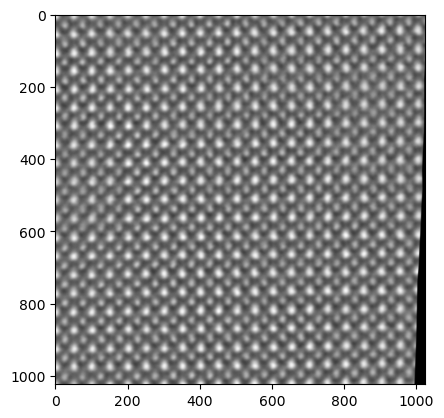

In [72]:
len_of_b_sum = []
#初始位移为0
t_b = np.array([0,0]).astype(np.float32)
#初始原点位置即定义的原点位置
O_x = o_x
O_y = o_y

#对之前调整过的a_0,b_0归一化，并且选取标准基矢，这个并不作为真实的a0，b0
#只是在去OA0和OB0的时候需要这个
a_0,b_0 = standard_a0,standard_b0
a_0 = a_0/np.linalg.norm(a_0)
b_0 = b_0/np.linalg.norm(b_0)

#对基矢长度进行初始化
len_of_a0, a_x, a_y = find_next_o(a_0,cen_x,cen_y,o_x,o_y)
len_of_b0, b_x, b_y = find_next_o(b_0,cen_x,cen_y,o_x,o_y)

#对初始a_x，a_y进行调整，调整到a_0方向
oA = np.array([a_x-o_x, a_y-o_y])
oA = a_0*np.linalg.norm(oA)
a_x = o_x + oA[0]
a_y = o_y + oA[1]

# origin_image = cv2.imread('image_re_noise.jpg')
# origin_image = cv2.cvtColor(origin_image, cv2.COLOR_BGR2GRAY)
# origin_image = origin_image.astype(np.float32)
# #图片已读取

drift_b_image = origin_image

origin_image_1 = origin_image.copy()

#记录T_b
drift_b_sum = []
T_b_sum = []

#到达边界find_center会将b_x,b_y重置为0，作为截止条件
while b_x > 0:
    #注意这里为首的是大写的O
    cen_O = np.array([O_x,O_y])
    oA0 = oA = np.array([a_x,a_y])-cen_O
    oB = np.array([b_x,b_y])-cen_O
    #求OB0
    theta = angle_vector(oB, b_0)
    fi = angle_vector(b_0, oA)
    oB0 = np.linalg.norm(oB)*np.sin((theta+fi)*np.pi/180)*b_0/np.sin(fi*np.pi/180)
    oC = oA + oB
    #位姿变换矩阵
    T_b_tran = drift_T_0(oA0, oB0, oA, oB)
    T_b = np.hstack((T_b_tran,t_b.reshape((-1, 1))))
    
    #记录T_b和漂移量
    #deta_b = drift_pix(angle=angle_b,distance=oB0[1]+cen_O[1],T=T_b,angle_change=angle_change_b)
    deta_b = drift_pix(distance=oB0[1]+cen_O[1],T=T_b,angle_change=angle_change_b)
    deta_b = deta_b*trans_pix_to_nm
    drift_b_sum.append(deta_b)
    T_b_sum.append(T_b)
    #对image_array对应位置进行变换，注意界限要避免从原子穿过
    drift_b_image = drift_image_y(image = drift_b_image, O_x=O_x, O_y=O_y, oA=oA, 
                                  b_x=b_x, b_y=b_y, r_mean=atom_r_mean, T_b=T_b.astype(np.float32))
#     test_image = origin_image_1
#     paint_point(test_image,b_x+np.int32(test[0]),b_y+np.int32(test[1]))
    #更新参数：原点位置
    O_x = b_x
    O_y = b_y   #这里也是大写的O
    #更新参数：A点位置
    a_x = oC[0] + cen_O[0]
    a_y = oC[1] + cen_O[1]
    #更新参数：B点位置
    len_of_bi, b_x, b_y = find_next_o(b_0,cen_x,cen_y,O_x,O_y)
    #print(b_0,cen_x,cen_y,O_x,O_y)
    #调整过后len_of_bi的大小
    len_of_bi = np.linalg.norm(oB0)
    len_of_b_sum.append(len_of_bi)
    #print(T_b)
    #更新参数：位移量,每次都累积,注意这个位移量的方向
    BB0 = oB0-oB
    t_b += BB0

drift_b_image = cv2_filter(drift_b_image ,choose = 4, core = 3)
drift_b_image = cv2_filter(drift_b_image ,choose = 1, core = 3)
#1高斯滤波
#2腐蚀操作
#3高斯双边滤波
#4中值滤波

plt.imshow(drift_b_image,cmap='gray')
cv2.imwrite('drift_b.png',drift_b_image,params=[cv2.IMWRITE_PNG_COMPRESSION,0])
plt.show()

In [73]:
#进行非线性漂移矫正,沿着x方向
def drift_image_x(image, O_x, O_y, oB, a_x, a_y, r_mean, T_a):
    img_x,img_y = image.shape
    #左上角,左下角,右上角，右下角的横坐标
    x_left = O_x - oB[0]*O_y/oB[1]
    #防止超出界限
#    x_left = np.sum(np.where(x_left-r_mean > 0, x_left-r_mean, 0))
    x_right = O_x + oB[0]*(img_x-O_y)/oB[1]
#    x_right = np.sum(np.where(x_right-r_mean > 0, x_right-r_mean , 0))
    x_left_1 = a_x - oB[0]*a_y/oB[1]
#    x_left_1 = np.sum(np.where(x_left_1-r_mean <= img_y, x_left_1-r_mean, img_y))
    x_right_1 = a_x + oB[0]*(img_x-a_y)/oB[1]
#    x_right_1 = np.sum(np.where(x_right_1-r_mean <= img_y, x_right_1-r_mean, img_y))
    
    height = np.int16(img_x)
    width = np.int16(x_left_1-x_left)
    
    #在碰到上下两端时，将上下空余区域纳入
    if x_left < width  or x_right < width:
        x_left = x_right = 0
    
    if img_x-x_left_1 < width  or img_x-x_right_1 < width:
        x_left_1 = x_right_1 = img_x
    
    #在碰到左右两端时，将左右空余区域纳入
    #使用了外部变量
    if O_x == o_x:
        x_left = x_right = 0
    len_of_next_a, next_a_x, next_a_y = find_next_o(a_0,cen_x,cen_y,a_x,a_y)
    if next_a_x == 0:
        x_left_1 = x_right_1 = img_x
    
    #平行四边形的四个顶点
    point = np.array([[x_left,0],[x_right,img_x],
                          [x_right_1,img_x],[x_left_1,0]],dtype = np.float32)
    
    # 创建一个 1024x1024 的黑色背景
    # 在原始图像上创建一个掩码，其中平行四边形区域为白色，其余区域为黑色
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    cv2.fillConvexPoly(mask, point.astype(np.int32), (255, 255, 255))

    # 提取感兴趣区域
    #分别向下，向上取整
    roi_left = np.int32(np.floor(min(x_right,x_left)))
    roi_right = np.int32(np.ceil(max(x_right_1,x_left_1)))
    roi_image = np.where(mask > 0, image, mask)
    roi = roi_image[0:img_y, roi_left:roi_right]
    
    #漂移矫正
    affined_roi = cv2.warpAffine(roi, T_a, (roi_right-roi_left,img_y))
    
    #填充回roi_image
    roi_image[0:img_y, roi_left:roi_right] = affined_roi
    
    # 将平行四边形区域填充回原图
    final_image = np.where(mask == 0, image, roi_image)

    return final_image

C:\Users\shiki\AppData\Local\Temp\ipykernel_23004\3184598420.py:7: RuntimeWarning: invalid value encountered in double_scalars
  cos_vector = dot_vector/(norm1*norm2)


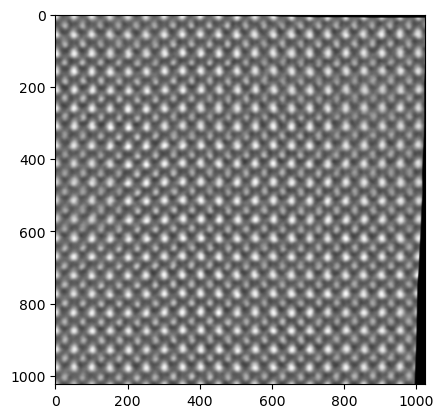

In [77]:
len_of_a_sum = []
#沿着a方向进行非线性漂移矫正
#初始位移为0
t_a = np.array([0,0]).astype(np.float32)
#初始原点位置即定义的原点位置
O_x = o_x
O_y = o_y

#对之前调整过的a_0,b_0归一化
a_0 = a_0/np.linalg.norm(a_0)
b_0 = b_0/np.linalg.norm(b_0)

#对基矢长度进行初始化
len_of_a0, a_x, a_y = find_next_o(a_0,cen_x,cen_y,o_x,o_y)
len_of_b0, b_x, b_y = find_next_o(b_0,cen_x,cen_y,o_x,o_y)

#b_0方向原子位置已经经过矫正，所以初始b_x，b_y要进行调整
oB = np.array([b_x-o_x, b_y-o_y])
oB = b_0*np.linalg.norm(oB)
b_x = o_x + oB[0]
b_y = o_y + oB[1]

drift_a_image = drift_b_image.copy()
test_image = drift_a_image.copy()

drift_a_sum = []
T_a_sum = []

#到达边界find_center会将a_x,a_y重置为0，作为截止条件
while a_x > 0:
    #注意这里为首的是大写的O
    cen_O = np.array([O_x,O_y])
    oA = np.array([a_x,a_y])-cen_O
    oB0 = oB = np.array([b_x,b_y])-cen_O
    #求OB0
    theta = angle_vector(oA, a_0)
    fi = angle_vector(a_0, oB)
    oA0 = np.linalg.norm(oA)*np.sin((theta+fi)*np.pi/180)*a_0/np.sin(fi*np.pi/180)
    
    #错误版本：oB0 = np.array([b_y*b_0[0]/b_0[1],b_y])-cen_O
    oC = oA + oB
    #位姿变换矩阵
    T_a_tran = drift_T_0(oA0, oB0, oA, oB)
    T_a = np.hstack((T_a_tran,t_a.reshape((-1, 1))))
    #print(T_a)
    #记录T_b和漂移量
    deta_a = drift_pix(distance=oA0[0]+cen_O[0],T=T_a,angle_change=angle_change_a)
    deta_a = deta_a*trans_pix_to_nm
    drift_a_sum.append(deta_a)
    T_a_sum.append(T_a)
    #对image_array对应位置进行变换，注意界限要避免从原子穿过
    drift_a_image = drift_image_x(image = drift_a_image, O_x=O_x, O_y=O_y, oB=oB, 
                                  a_x=a_x, a_y=a_y, r_mean=atom_r_mean, T_a=T_a.astype(np.float32))
#     paint_point(test_image,a_x+np.int32(test[0]),a_y+np.int32(test[1]))
    #更新参数：原点位置
    O_x = a_x
    O_y = a_y   #这里也是大写的O
    #更新参数：A点位置
    b_x = oC[0] + cen_O[0]
    b_y = oC[1] + cen_O[1]
    #更新参数：B点位置
    len_of_ai, a_x, a_y = find_next_o(a_0,cen_x,cen_y,O_x,O_y)
    #调整过后len_of_ai的大小
    len_of_ai = np.linalg.norm(oA0)
    len_of_a_sum.append(len_of_ai)
    #print(b_x)
    #paint_point(drift_a_image,O_x,O_y)
    #更新参数：位移量,每次都累积  
#     AA0 = np.linalg.norm(oA)*np.sin(theta*np.pi/180)*oB/(np.sin(fi*np.pi/180)*np.linalg.norm(oB))
#     #调整T_a方向
#     if oA0[0] < oA[0]:
#         AA0 = -AA0
    AA0 = oA0-oA
    t_a += AA0

drift_a_image = cv2_filter(drift_a_image ,choose = 4, core = 3)
drift_a_image = cv2_filter(drift_a_image ,choose = 1, core = 3)
#1高斯滤波
#2腐蚀操作
#3高斯双边滤波
#4中值滤波

plt.imshow(drift_a_image,cmap='gray')
cv2.imwrite('drift_a.png',drift_a_image,params=[cv2.IMWRITE_PNG_COMPRESSION,0])
plt.show()

In [78]:
print(drift_a_sum)
print(drift_b_sum)

#drift of each layer
writer = pd.ExcelWriter('drift.xlsx')
drift_a_text = pd.DataFrame(drift_a_sum)
drift_a_text.to_excel(writer, sheet_name='drift_a', index=False)
drift_b_text = pd.DataFrame(drift_b_sum)
drift_b_text.to_excel(writer, sheet_name='drift_b', index=False)
writer.save()

[0.0, 0.0076045627376425855, 0.022813688212927757, 0.030418250950570342, 0.03802281368821293, 0.030418250950570342, 0.022813688212927757, 0.022813688212927757, 0.030418250950570342, 0.045627376425855515, 0.045627376425855515, 0.03802281368821293, 0.053231939163498096, 0.060836501901140684, 0.06844106463878327, 0.06844106463878327, 0.06844106463878327, 0.07604562737642585, 0.07604562737642585]
[0.0, 2.3747903638847072e-17, 4.796145317331002e-17, 0.015209125475285171, 0.015209125475285171, 0.015209125475285171, 0.022813688212927757, 0.045627376425855515, 0.060836501901140684, 0.053231939163498096, 0.07604562737642585, 0.09125475285171103, 0.11406844106463879, 0.12927756653992395, 0.1596958174904943, 0.16730038022813687, 0.17490494296577946, 0.18250950570342206, 0.19771863117870722]


0.3810286171703022 0.3890334200520312


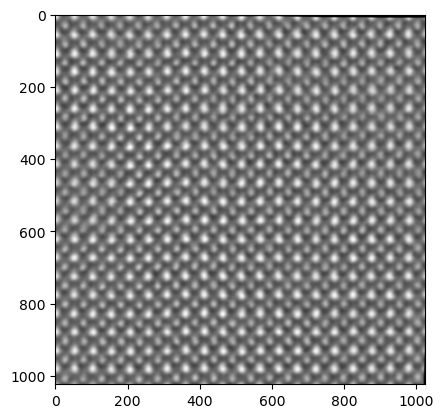

In [79]:
#在整体上加一个缩放矩阵，调整比例
#我们只取标准a_0,b_0的方向，长度从输入的比值选取
#这里就是为了取一个准确值，并且依据此对图片进行矫正
len_of_a_mean = np.mean(len_of_a_sum)
len_of_b_mean = np.mean(len_of_b_sum)

print(len_of_a_mean*trans_pix_to_nm, len_of_b_mean*trans_pix_to_nm)

#a_0,b_0即归一化之后的标准a_0,b_0
a = len_of_a_mean * a_0
b = len_of_b_mean * b_0
# #这里选取a的长度为基准长度,即默认值1；改为2则取b为标准长度
# def len_standard(a_b = 1, a_mean = len_of_a_mean, b_mean = len_of_b_mean):
#     if a_b == 1:
#         return a_mean
#     else:
#         return b_mean

standard_a = len_of_standard_a0 * a_0/trans_pix_to_nm
standard_b = len_of_standard_b0 * b_0/trans_pix_to_nm

#缩放矩阵
T_scale = drift_T_0(standard_a, standard_b, a, b)
T_scale = np.hstack((T_scale,np.array([0,0]).reshape((-1, 1))))


img_x, img_y = drift_a_image.shape
#图像缩放,注意T的类型
final_affined = cv2.warpAffine(drift_a_image, T_scale.astype(np.float32), (img_x,img_y))

plt.imshow(final_affined,cmap='gray')
cv2.imwrite('drift_all.png',final_affined,params=[cv2.IMWRITE_PNG_COMPRESSION,0])
plt.show()